# **Introduction**
As a group of wine enthusiasts, we have tried different wines, whose prices range from low to high. We want to 
figure out how to pick out a bottle of good wine based on information available on the bottle. For example, should we always pick the most expensive wine? Or we need to consider wine form specific countries or regions? With information and score from over 130k bottle of wines, we are going to discover the secret behind wine picking. Hope our model can help your future wine picking, cheers!

---


The original data set can be found here: https://www.kaggle.com/zynicide/wine-reviews 

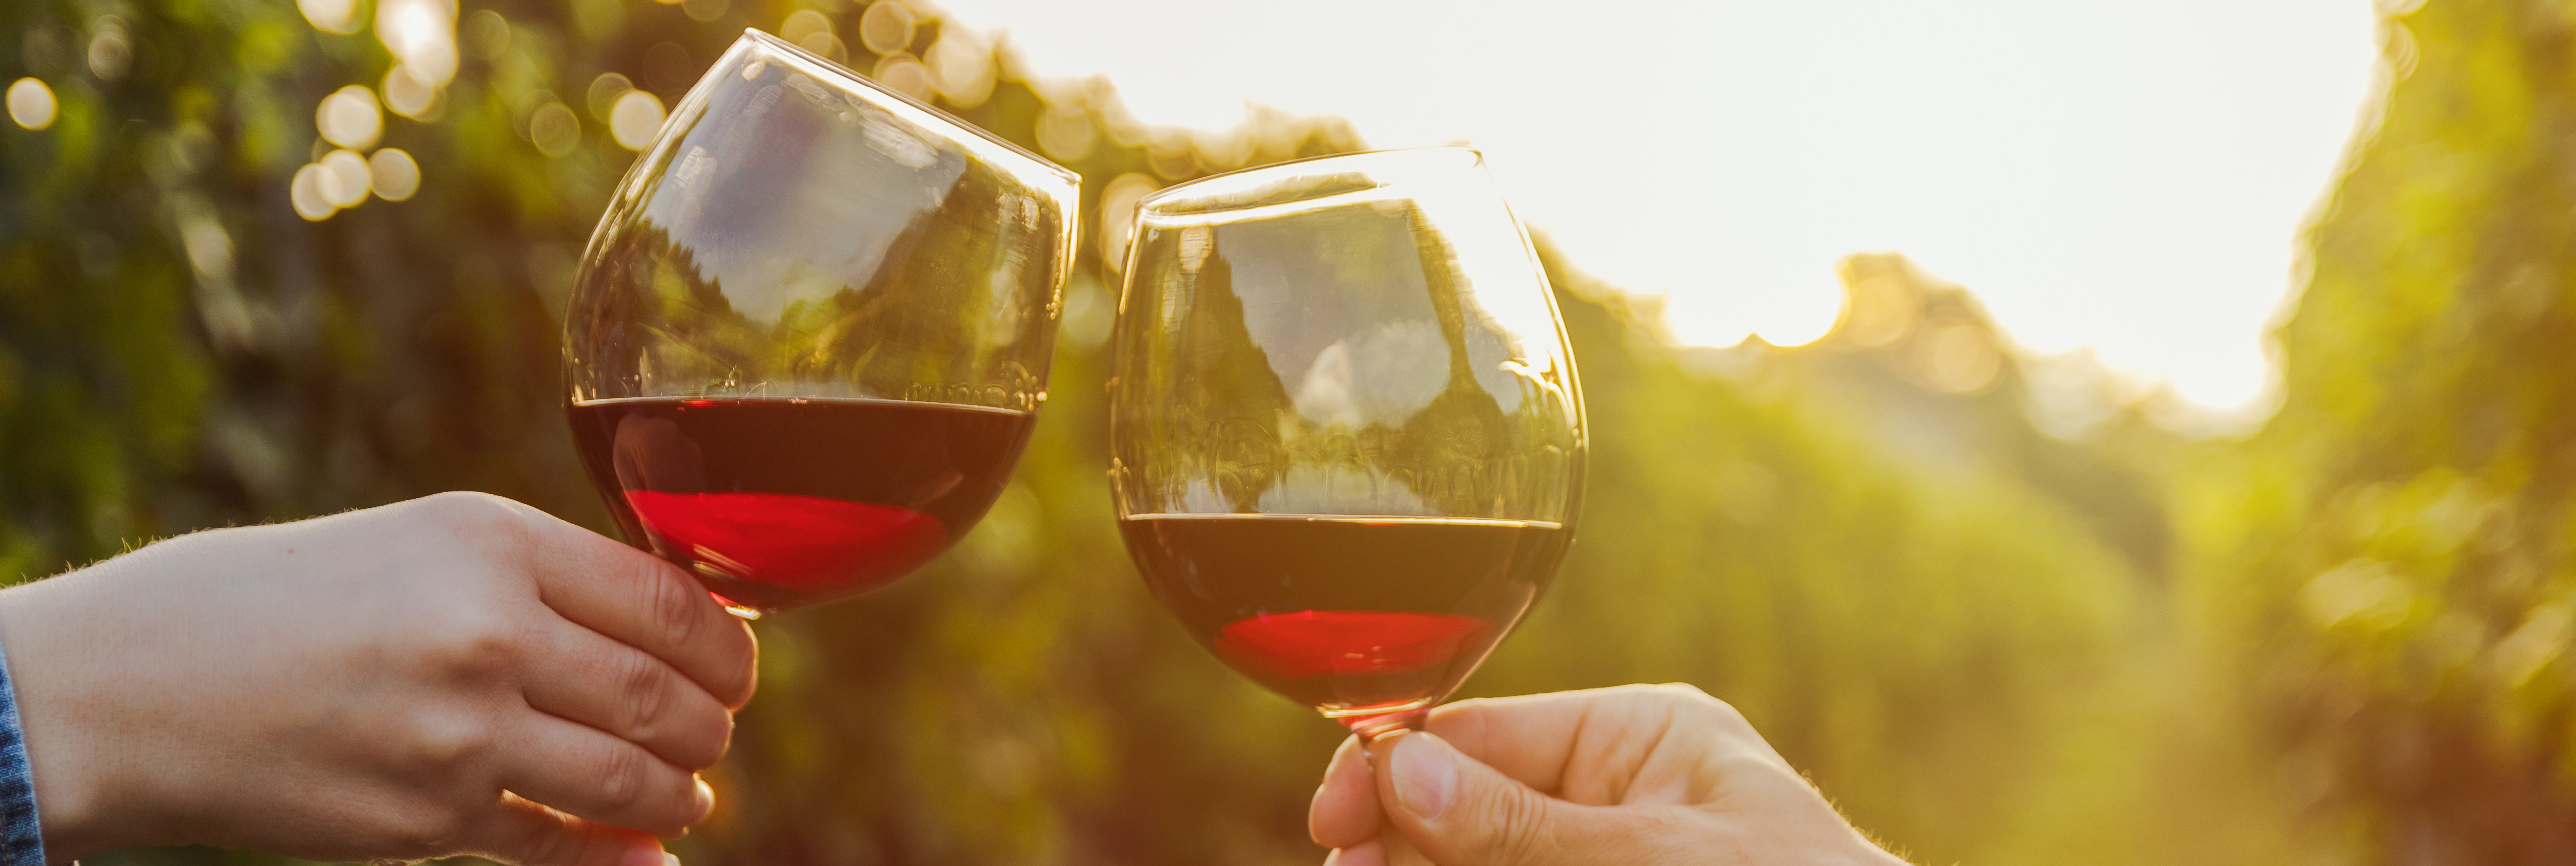

# **Data** **Preprocessing**


In this section we are going to clean our dataset, including dropping duplicates and unnecessary columns, extracting a possible feature from original data, imputing missing values, and finally, dropping the remaining nan values.

##1.1 Loading Packages and Dataset

In [ ]:
!pip3 install pandas==1.0.5
!pip3 install catboost
!pip install pandasql

In [ ]:
import pandas as pd
print(pd.__version__ == '1.0.5')

In [ ]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandasql as ps
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
import pickle

In [ ]:
# mount your google drive
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
#please download the dataset through kaggle link in the intro section and upload it to your google drive. 
#Now we can load the data set into a pandas dataframe
wine_df = pd.read_csv('/content/gdrive/My Drive/winemag-data-130k-v2.csv')
wine_df = wine_df.rename(columns={'Unnamed: 0' : 'wine_id'}).set_index('wine_id')

##1.2 Data Cleaning

###1.2.1 Drop the duplicates and unnecessary columns
We start the cleaning process by dropping duplicates and unnecessary columns

In [ ]:
#first, drop duplicates
wine_df = wine_df.drop_duplicates()
# drop the unnecessary columns
wine_df = wine_df.drop(columns=['region_2','taster_twitter_handle','taster_name','designation'])
wine_df = wine_df.rename(columns={'region_1': 'region'})

###1.2.2 Extract 'Vintage Year' from the title of wine

Vintage Year is what we consider an important feature, as we know that the year with better weather conditions will produce grapes of higher quality, which may influence the points of the wine.

There are two types of wine, vintage wine, and non-vintage wine. If it is a vintage wine, it means that it was produced by grapes from a single year, as for the non-vintage wine, it is created by blending several wines from different vintage years.

How can we know if the wine is vintage wine or not? We can get the information by looking at the title of the bottle of wine. If the title of wines doesn't have a year on it and contains the word "NV", it means that it is a non-vintage wine. If it is a vintage wine, it will have the year on the title.











In [ ]:
# function to find the vintage year in the title of wines
# return '' if doesn't find possible year (1900 - 2020) or 'NV' in the title
def find_year(x):

  # check if it is non-vintage wine, in title, NV means Non Vintage wine
  if ' NV ' in x :
    return 'nv'

  # if it is not non-vintage wine, find the year
  s = re.findall('\d{4}', x) #list for the numbers with 4 digits in the title
  if len(s) == 0:
    return ''
  y = [] # list to store the possible value of vintage year (from 1900 to 2020)
  for v in s:
    if int(v) >= 1900 and int(v) <= 2020 :
      y.append(v)  
  if(len(y) > 0):
    return max(y) # some titles contain the founded year of winery , so the larger value in the list(y) is the correct vintage year
 
  return '' 

In [ ]:
wine_df['vintage_year'] = wine_df['title'].apply(lambda x : find_year(x))

# if doesn't find year or nv, turn the data into nan value
wine_df['vintage_year'] = wine_df['vintage_year'].replace('', np.nan) 

#check the nan values in vintage year
wine_df['vintage_year'].isnull().sum() 

0

 We don't know the years of non-vintage wines. However, we do not want to drop those data, so it is better to give them some reasonable values, and what we choose is the median of the year. At the same time, we also create a new column called non_vintage to identify whether it is non-vintage wine or not.


In [ ]:
 #create column to identify vintage and non-vintage wine
 wine_df['non_vintage'] =  wine_df['vintage_year'].apply(lambda x : True if x == 'nv' else False)
 
 # replace the vintage year for non-vintages wines with nan value
 wine_df['vintage_year'] = wine_df['vintage_year'].replace('nv', np.nan)

 # find the median
 tmp = wine_df[wine_df['vintage_year'].notnull()].copy()
 median = tmp['vintage_year'].astype(int).median()
 median

2011.0

In [ ]:
#impute the nan value with median(2011)
wine_df['vintage_year'] = wine_df['vintage_year'].fillna(median) 

###1.2.3 Handling NaN value in the dataset
We then move to the NaN values in our dataset. We need to decide on either dropping the NaN values or filling in values manually

There shouldn't be any nan values in our dataset when modeling, so let's check the nan values in our dataset first.

In [ ]:
print(wine_df.isna().sum())

country            59
description         0
points              0
price            8395
province           59
region          19560
title               0
variety             1
winery              0
vintage_year        0
non_vintage         0
dtype: int64


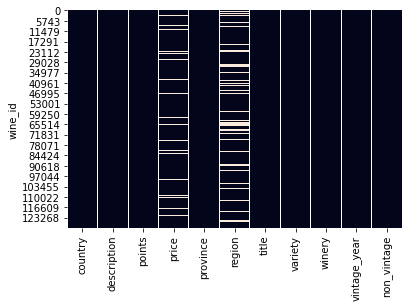

In [ ]:
sns.heatmap(wine_df.isnull(), cbar=False)

In [ ]:
print('{:.2%}'.format(wine_df['region'].isnull().sum()/len(wine_df)))

16.30%


We can see that there are many missing values in the region column. We can't just drop the nan values, since it is 16.3% of our data. Fortunately, we can find the region of the wine in their title. For example, for the title "Franz Haas 2009 Sauvignon (Alto Adige)", we can extract Alto Adige as its region.


In [ ]:
## function to find the region in title
def find_region(x):
  if '(' in x:
    s = x.split("(")[-1] # if title contains region, it must be in the last parentheses
    if s[-1] == ')':
      return s[0:-1]
    else:
      return s 
  return '' #return '' if doesn't extract anything

In [ ]:
# store the region extracted from title into column 'region_fix'
wine_df['region_fix'] = wine_df['title'].apply(lambda x : find_region(x))

## fill the nan value in region column
wine_df['region'] = wine_df['region'].fillna(wine_df['region_fix']) 

# set the value back to nan if still can't find the region
wine_df['region'] = wine_df['region'].replace('', np.nan)

wine_df = wine_df.drop(columns=['region_fix','title']) 

In [ ]:
print(wine_df.isna().sum())

country           59
description        0
points             0
price           8395
province          59
region           380
variety            1
winery             0
vintage_year       0
non_vintage        0
dtype: int64


Great. The number of missing values in the region have now become 380.

Now let's drop the remaining nan values in the dataset

In [ ]:
wine_df = wine_df.dropna()

After cleaning the nan value, we can turn the vintage year into integer

In [ ]:
wine_df['vintage_year'] = wine_df['vintage_year'].astype(int)

# **EDA and Feature Engineering**
In this section, we are going to investigate our data, such as the distribution of numeric features and the distribution of points against categorical featrues, and more.

##2.1 Simple statistic
We start by looking at some simple statistics like mean, standard deviation, min and max for each of the numerical features in the dataset. We will analyze each data in details in the following sections.



In [ ]:
wine_df.describe()

,points,price,vintage_year
count,111230.000000,111230.000000,111230.000000
mean,88.418071,35.661377,2010.644134
std,3.099507,42.159258,3.643731
min,80.000000,4.000000,1934.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,25.000000,2011.000000
75%,91.000000,42.000000,2013.000000
max,100.000000,3300.000000,2017.000000


##2.2 Distribution : *ponits*, *price*, *vintage year* 
For each data we will take a look at their distribution, outliers and then make decisions on whether we should scale our data.



We defined a function to count and print out the percentage of the outliers

In [ ]:
# df: dataframe, name : column that we want to check the outliers
def count_outlier(df, name):
  Q3 = np.percentile(df[name], 75)
  Q1 = np.percentile(df[name], 25)
  iqr = 1.5 * (Q3 - Q1)
  outlier = [x for x in df[name] if x < (Q1 - iqr) or x > (iqr + Q3)] # list for the outliers
  print('Outlier percentage in '+ name+': '+'{:.2%}'.format(len(outlier)/len(wine_df))) # count and print out percentage

###2.2.1 Points Distribution

Let's take a look at the points distribution first.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


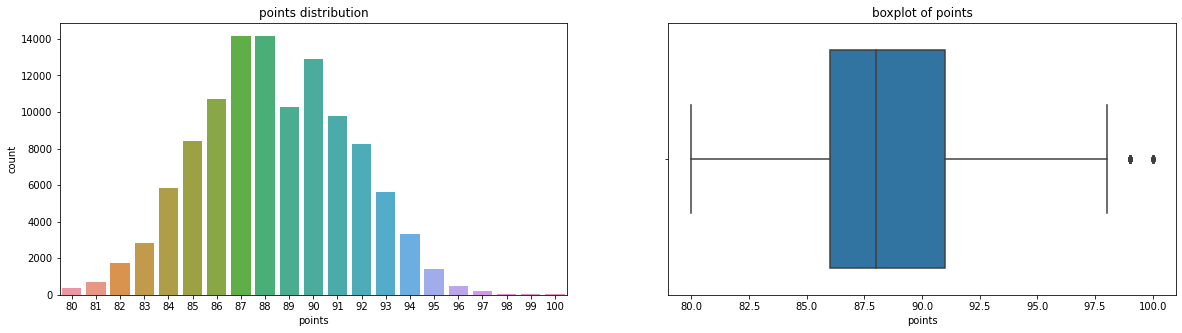

In [ ]:
#plot the points distribution
fig, axes = plt.subplots(1, 2,figsize=(20,5))

axes[0].set_title("points distribution")
g = sns.countplot(wine_df['points'], ax= axes[0])

axes[1].set_title("boxplot of points")
g = sns.boxplot(wine_df['points'], ax= axes[1])

In [ ]:
count_outlier(wine_df, 'points')

Outlier percentage in points: 0.04%


We can see from the plot that the distribution of the points is similar to the normal distribution. Only a few data(0.04%) are outliers so we don't need to scale our data

### 2.2.2 Price Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


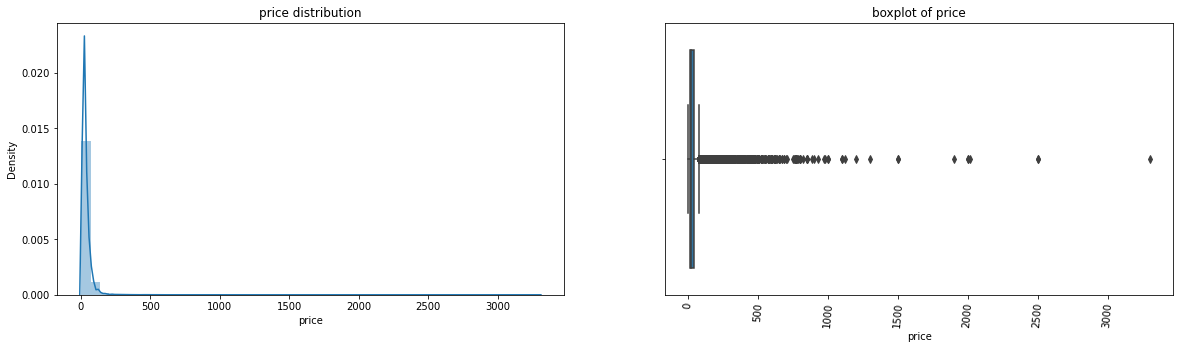

In [ ]:
#plot the price distribution
fig, axes = plt.subplots(1, 2,figsize=(20,5))

axes[0].set_title("price distribution")
g = sns.distplot(wine_df['price'], ax= axes[0])
plt.xticks(rotation=85) 

axes[1].set_title("boxplot of price")
g = sns.boxplot(wine_df['price'], ax= axes[1])


In [ ]:
count_outlier(wine_df, 'price')

Outlier percentage in price: 6.17%


It is skewed-right distribution and there are a lot of outliers in the price column (6.17%). Outliers sometimes will influence our machine learning model, so we need to find a way to reduce the influence. Removing the data is one of the methods, but the occurrence of outliers in price is not due to the entry error, so it is better to keep them in our dataset. The range of the price is quite large(4-3300(USD)), so we try rescaling the data to log scale (base e) to handle those outliers. After transformation, the variance caused by the outliers can be reduced.

In [ ]:
# create the dataframe with price in log scale for future analysis in EDA
log_df = wine_df.copy() 
log_df['price_log'] = log_df['price'].apply(lambda x : np.log(x))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


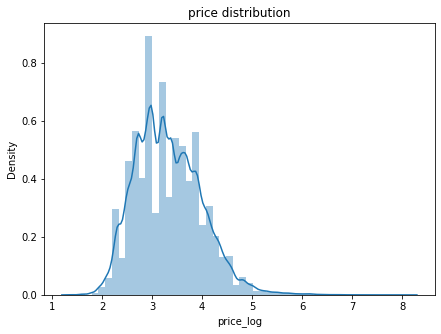

In [ ]:
#plot the distribution of price_log
plt.figure(figsize=(7,5))
plt.title("price distribution")
sns.distplot(log_df['price_log'])

After rescaling, it looks more like normal distribution. Now let's take a look at the top 100 most expensive wines.

In [ ]:
# dataframe for top100 most expensive wines
top100_p = log_df.sort_values('price_log', ascending = False)[:100] 

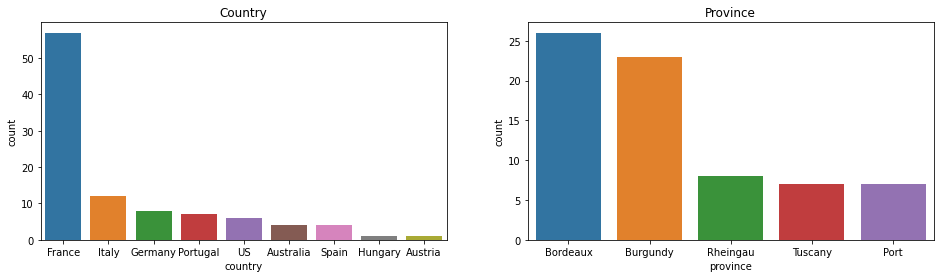

In [ ]:
fig, axes = plt.subplots(1, 2,figsize=(16,4))

#plot the count of the country for top100_p
axes[0].set_title("Country")
sns.countplot(x=top100_p.country, order=top100_p.country.value_counts().index, ax=axes[0])

#plot the count of the province for top100_p
axes[1].set_title("Province")
sns.countplot(x=top100_p.province, order=top100_p.province.value_counts().iloc[:5].index, ax=axes[1])

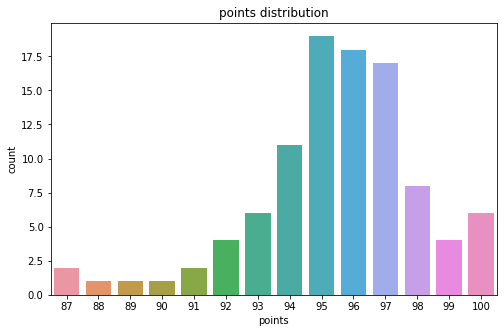

In [ ]:
#plot the points distribution for top100_p
plt.figure(figsize=(8,5))
plt.title("points distribution")
sns.countplot(x='points', data=top100_p)

Most of the expensive wines in our dataset are from Bordeaux and Burgundy in France, which is not surprising since Bordeaux and Burgundy are famous for high-quality wines. From the points distribution of the top 100 most expensive wines, we can notice that the median of points is much higher than the median of our whole dataset. The idiom "You get what you pay for" comes to our mind, so let's create the scatterplot for points and price to see if the wines got higher points when more expensive.

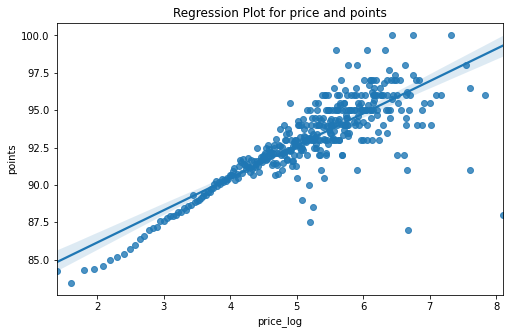

In [ ]:
plt.figure(figsize=(8,5))
price = log_df.groupby(by='price_log').mean().reset_index()
plt.title("Regression Plot for price and points")
sns.regplot(x = 'price_log', y = 'points', data= price)

Interestingly, the idiom is true. For the more expensive wines, they seem to have better taste. Points and Price seem to have high liner relationship, as a result, when predicting the points, price is definitely an important feature.

### 2.2.3 Vintage Year Distribution

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'boxplot of vintage year')

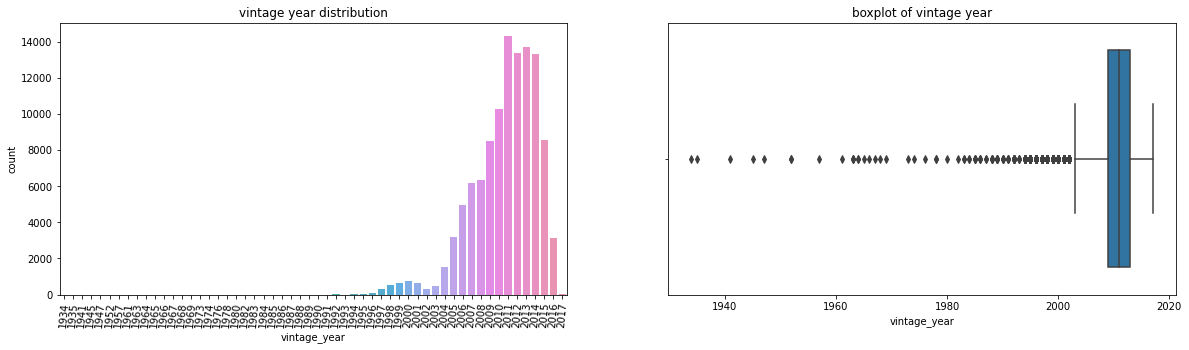

In [ ]:
#plot the vintage year distribution
plt.figure(figsize=(20,5))
plt.subplot(1,2,1) 
g = sns.countplot(x='vintage_year', data=wine_df)
plt.title("vintage year distribution")
plt.xticks(rotation=85) 

plt.subplot(1,2,2)
g = sns.boxplot(wine_df['vintage_year'])
plt.title("boxplot of vintage year")

In [ ]:
count_outlier(wine_df, 'vintage_year')

Outlier percentage in vintage_year: 3.04%


It is skewed-left distribuiton and there are also outliers in the vintage year column (3.04%). Again, it is the natural outliers so we need to keep them. However, the range of the vintage year is small (1934 - 2017), so rescaling may not have a significant impact on the data. As a result, we will just use the original data.

##2.3 Points against categorical features
After looking at numerical features, we decided to take a look at categorical features. We picked country, region, and variety. 

###2.3.1 Distribution of points against Country

From the previous analysis, we know that expensive wines are from France and they have higher points. We also know that other famous countries for wine production in the world are Italy, Spain, and the US. So we take a look at the distribution of points against countries to see which country got higher points. Do wines from these famous countries get higher points? We use the mean points in each country to decide the sequence.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

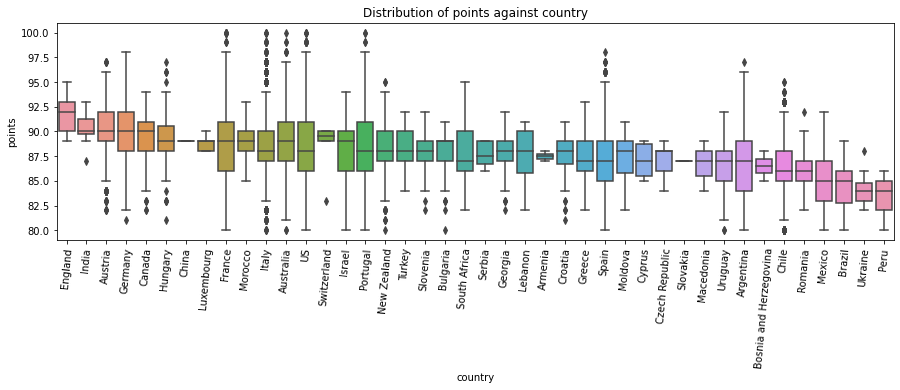

In [ ]:
plt.figure(figsize=(15,4))
plt.title("Distribution of points against country")
sorted_c = log_df.groupby(['country'])['points'].mean().sort_values(ascending = False) #sort by median price
sns.boxplot(x=log_df['country'], y=log_df['points'],order = list(sorted_c.index))
plt.xticks(rotation = 85)

Wines in England and India have a higher points, not Itlay and France. Perhaps it is because there is only a small amount of data from England so that England's wines got a really high points. Count plot for countries can answer our question.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

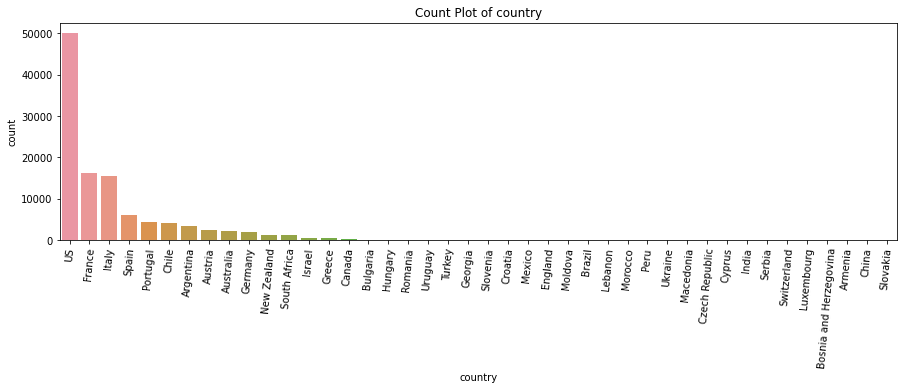

In [ ]:
#count plot of country
plt.figure(figsize=(15,4))
plt.title("Count Plot of country")
sns.countplot(x=wine_df.country, order=wine_df.country.value_counts().index)
plt.xticks(rotation = 85)

In [ ]:
# print out the number of wines from England and India
print('England:',len(wine_df[wine_df['country'] == 'England']),', India:',len(wine_df[wine_df['country'] == 'India']))

England: 59 , India: 8


Most of the wines in our dataset come from famous wine production countries like US, France, Italy, Spain, and Portugal. There is just small amount of data from England and India, so it may be a little bit inaccurate to say that the wine points in these two countries is higher than others. It is better to discuss the points for the countries that most of our data comes from. It seems that we can just look at the top10 countries and discuss their points.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

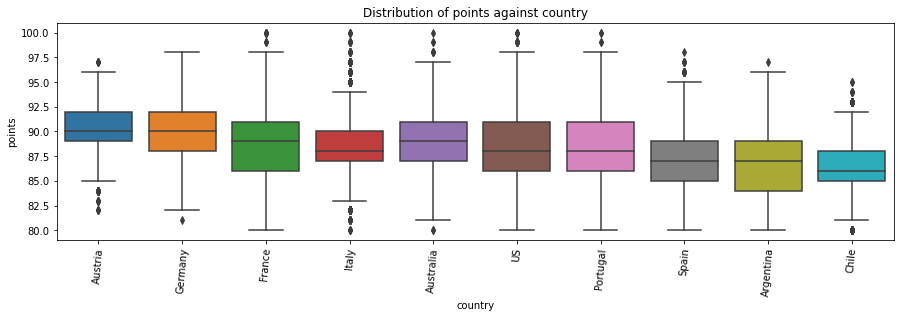

In [ ]:
plt.figure(figsize=(15,4))
plt.title("Distribution of points against country")
country =log_df['country'].value_counts()[:10]
top10_c = log_df[log_df['country'].isin(country.index.values)] 
sorted_c = top10_c.groupby(['country'])['points'].mean().sort_values(ascending = False)
sns.boxplot(x=top10_c['country'], y=top10_c['points'],order = list(sorted_c.index))
plt.xticks(rotation = 85)

Now Germany and Austria becomes the country with the highest points. Surprisingly, France and Italy are still not in the top.

###2.3.2 Distribution of points against Region

Italy is famous for wine production, but more accurately, it is famous for the wine regions such as Barolo in Piedmont. Maybe we should look at the distribution of points against regions. There are too many regions in our dataset, so we only look at the top 15 regions and order them by the mean points.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

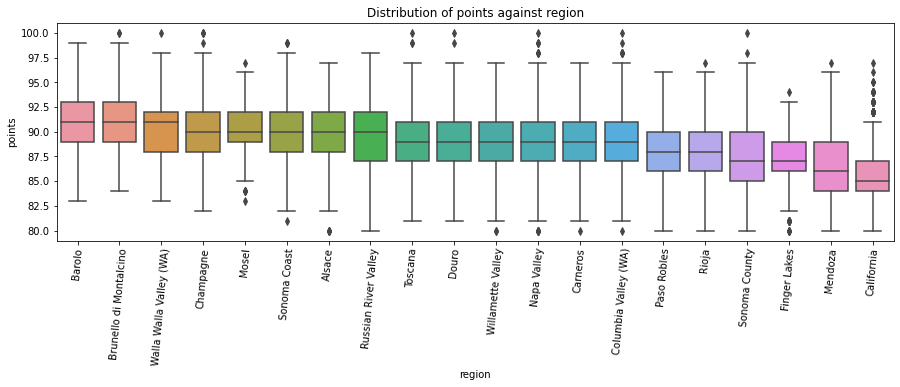

In [ ]:
plt.figure(figsize=(15,4))
plt.title("Distribution of points against region")
region =log_df['region'].value_counts()[:20] #top20 regions
top20_r = log_df[log_df['region'].isin(region.index.values)] 
sorted_r = top20_r.groupby(['region'])['points'].mean().sort_values(ascending = False)
sns.boxplot(x=top20_r['region'], y=top20_r['points'],order = list(sorted_r.index))
plt.xticks(rotation = 85)

Regions with higher points are Barolo(Italy), Montalcino(Italy), Walla Walla Valley(US), Champagne(France), and Mosel(Germany). These are all famous wine regions in the world! If we only look at the country, we may only recommend wines in Austria and Germany and miss the country like France, Italy and US. However, if we look into the region, Barolo from Italy will be on the top list. Therefore, it is better to consider the countries and regions at the same time when predicting the points.


### 2.3.3 Distribution of points against Variety

We are also interested in the relationship between variety and wine points, let's take a look at the distribution against the variety. Again, there are too many variety, so we only look at the top15

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

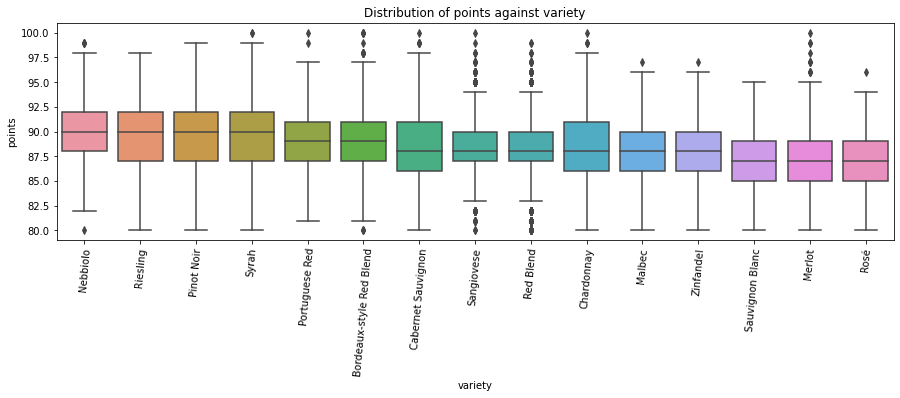

In [ ]:
plt.figure(figsize=(15,4))
plt.title("Distribution of points against variety")
variety =log_df['variety'].value_counts()[:15]
top15_v = log_df[log_df['variety'].isin(variety.index.values)] 
sorted_v = top15_v.groupby(['variety'])['points'].mean().sort_values(ascending = False)
sns.boxplot(x=top15_v['variety'], y=top15_v['points'],order = list(sorted_v.index))
plt.xticks(rotation = 85)

Wines made of Nebbiolo, Riseling and Pinot Noir have higher points comparing to other varieties. We know that Barolo produces a lot of Nebbiolo, will this be the reason that Barolo got higher points?

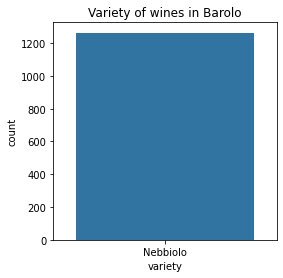

In [ ]:
plt.figure(figsize=(4,4))
barolo = wine_df[wine_df['region'] == 'Barolo']
plt.title("Variety of wines in Barolo")
sns.countplot(x=barolo.variety, order=barolo.variety.value_counts().index)

In our dataset, Barolo only produce wines made of Nebbiolo, so this may be the reason why wines from Barolo got the higher points.

##2.4 Vintage and Non-Vintage Wine
Since there are vintage wine and non-vintage wine in our dataset. We want to know their proportion in our dataset.



*Proportion of the vintage and non-vintage wine*

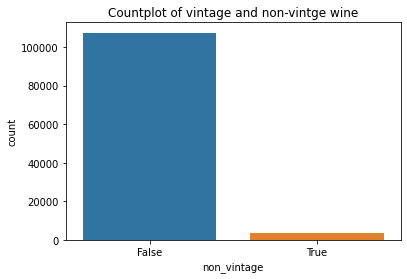

In [ ]:
plt.title("Countplot of vintage and non-vintge wine")
sns.countplot(x = 'non_vintage', data= wine_df)

In our dataset, most of the bottle of wine are vintage wine. Let's separate them into two dataframe and do some analysis.

In [ ]:
#two dataframe for vintage wine and non-vintage wine
non_v = log_df[log_df['non_vintage'] == True].copy()
v = log_df[log_df['non_vintage'] == False].copy()

*Country, Region Varitey for vintage wine and non-vintage wine*

From the plots below, we observed:
 
Non-Vintage wine: most of the non-vintage wines are from Champagne, France. Sparkling blend and Champagne Blend are the most common non-vintage wine in our dataset.

Vintage wine: most of the vintage wines are from Napa Valley, US. Most of the vintage wines are made of Pinot Noir and Chardonnay.


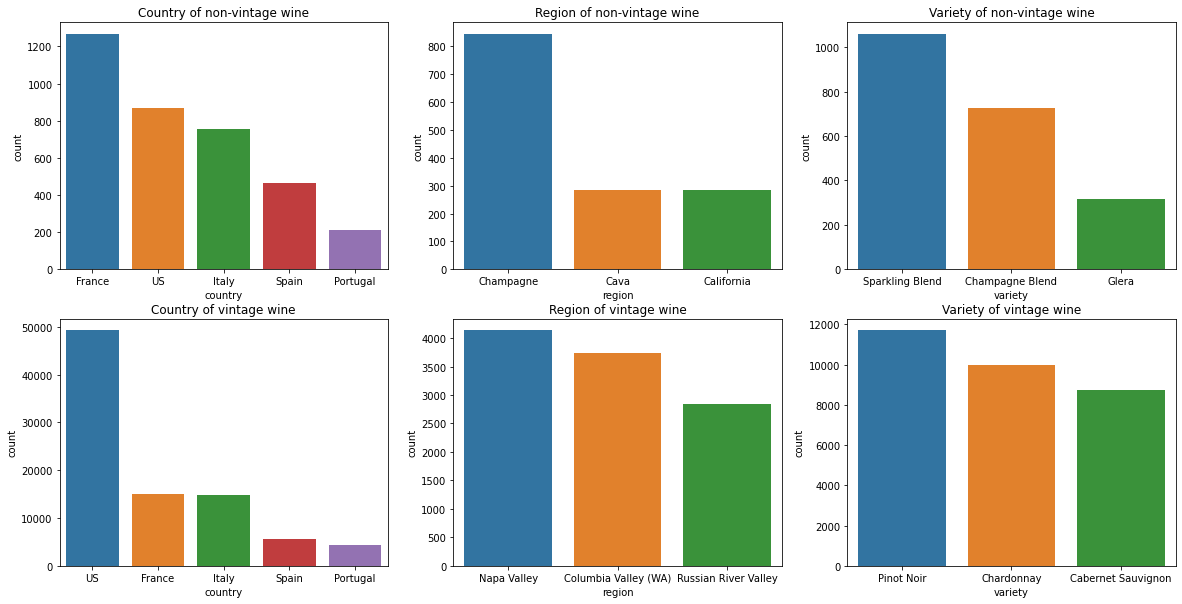

In [ ]:
fig, axes = plt.subplots(2, 3,figsize=(20,10))

axes[0,0].set_title("Country of non-vintage wine")
sns.countplot(x=non_v.country, order=non_v.country.value_counts().iloc[:5].index, ax=axes[0, 0])

axes[1,0].set_title("Country of vintage wine")
sns.countplot(x=v.country, order=v.country.value_counts().iloc[:5].index, ax=axes[1, 0])

axes[0,1].set_title("Region of non-vintage wine")
sns.countplot(x=non_v.region, order=non_v.region.value_counts().iloc[:3].index, ax=axes[0, 1])

axes[1,1].set_title("Region of vintage wine")
sns.countplot(x=v.region, order=v.region.value_counts().iloc[:3].index, ax=axes[1, 1])

axes[0,2].set_title("Variety of non-vintage wine")
sns.countplot(x=non_v.variety, order=non_v.variety.value_counts().iloc[:3].index, ax=axes[0, 2])

axes[1,2].set_title("Variety of vintage wine")
sns.countplot(x=v.variety, order=v.variety.value_counts().iloc[:3].index, ax=axes[1, 2])


*Points distribution of vintage and non-vintage wine*

Many vintages wines are made of Pinot Noir. We know that Pinot Noir has high points, so let's take a look at the points distribution for vintgae wine and non-vintage wine to see if there are some interesting phenomenon.


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


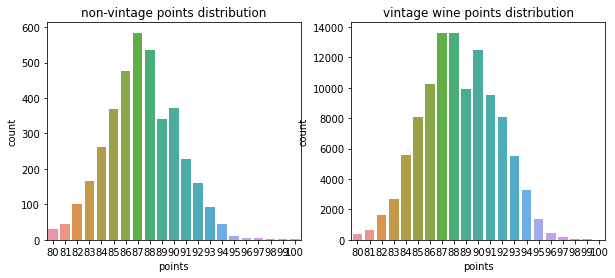

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("non-vintage points distribution")
ax = sns.countplot(non_v['points'])

plt.subplot(1,2,2)
plt.title("vintage wine points distribution")
ax = sns.countplot(v['points'])

In fact, Points distribution looks similar for vintage wines and non-vintage wines. However, we can still notice that vintage wine has more wines in the high-points region.

##2.5 Line Plot for vintage year and points

Vintage year may influence the quality of grapes in different regions and therefore influnce the points, so let's take a look at the line plot for vintage year and points in some representative wine regions like Barolo(Italy), Champagne(France), and Napa valley(US). We only analyze the data of vintage wine since the vintage year of non-vintage wine comes from imputation.

In [ ]:
v_o = wine_df[wine_df['non_vintage'] == False] #vintage wine dataset
year =v_o['vintage_year'].value_counts()[:15] #top15 year
v_o = v_o[v_o['vintage_year'].isin(year.index.values)] 
group = v_o.groupby(['region','vintage_year']).mean().reset_index()
other = group[group['region'].isin(['Champagne','Napa Valley','Barolo'])]

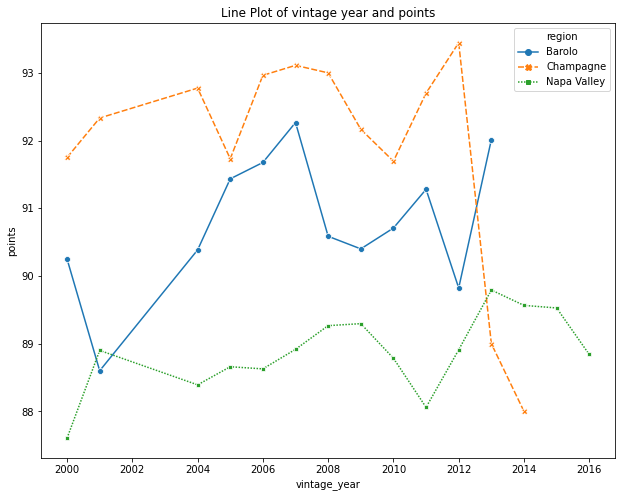

In [ ]:
plt.figure(figsize=(35,8))
plt.subplot(1,3,1)
plt.title("Line Plot of vintage year and points")
ax = sns.lineplot(x="vintage_year", y="points", hue = 'region',data=other, markers= True, style='region')

From the plot, we can see that the importance of vintage year is different between regions. The fluctuation of points in Champagne and Barolo are larger than in Napa Valley, which indicates that the weather in Champagne and Barolo varies a lot each year and will have a great impact on the quality of the grapes. For Napa Valley, the weather seems to be more steady, so vintage year may not be an important factor for the wine points in these two regions. However, that vintage year will influence the points in differnet regions is obvious.


##2.6 Rescale price to log scale (base e)

After the EDA, we can now turn our price to log scale.

In [ ]:
wine_df['price_log'] = wine_df['price'].apply(lambda x : np.log(x))
wine_df = wine_df.drop(columns='price')

# **NLP**
In this section, we focus on the description of wines. We are going to use NLP to do word tokenization and cleaning, and generate the word cloud to see the most common word in our descriptioins. Then we use VADER to do sentiment analysis.

## 3.1 Words tokenization and cleaning

The points may largely depend on the quality of the wine, and the description from reviewers may reflect its quality. So we want to do a text analysis of the descriptions to see the relationship between description and points. We will start with the word tokenization and cleaning.

In [ ]:
#import necessary packages like nltk, wordcloud
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We use regex to substitude the unnecessary words in the text with space and tokenize the text.

In [ ]:
wine_df['description'] = wine_df['description'].str.lower() #turn the word into lowercase
# we are only looking for the 'words', digital number are unnecessary
wine_df['description'] = wine_df['description'].apply(lambda x:re.sub('[^A-Za-z]+', ' ', x))

Let's take a look at cleaned description. Great, the descriptions now only contain letters.

In [ ]:
wine_df['description']

wine_id
1         this is ripe and fruity a wine that is smooth ...
2         tart and snappy the flavors of lime flesh and ...
3         pineapple rind lemon pith and orange blossom s...
4         much like the regular bottling from this comes...
5         blackberry and raspberry aromas show a typical...
                                ...                        
129966    notes of honeysuckle and cantaloupe sweeten th...
129967    citation is given as much as a decade of bottl...
129968    well drained gravel soil gives this wine its c...
129969    a dry style of pinot gris this is crisp with s...
129970    big rich and off dry this is powered by intens...
Name: description, Length: 111230, dtype: object

In [ ]:
 #tokenize the text
wine_df['description'] = wine_df['description'].apply(lambda x: word_tokenize(x))

Next, we remove stopwords and use Stemmer and Porter to do the Lexicon Normalization. Stemmer can reduce words to their root word, For example, it can turn the word "thought" to "think. As for Porter, it is responsible for the lemmatization of each word, which can reduce the word to their base word. For example, turn "better" into "good".

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
stopwords = set(stopwords.words('english')) 
wine_df['description'] = wine_df['description'].apply(lambda x:[word for word in x if word not in stopwords])
word_list = wine_df['description'].tolist()
cleaned_word = []
for l in word_list:
  for w in l:
    cleaned_word.append(w)
wine_df['description'] = wine_df['description'].apply(lambda x:[ps.stem(word) for word in x])

## 3.2 Generating a wordcloud

After tokenization and cleaning, we can find the most common words used in description, and generate a wordcloud based on that. Most frequent descriptions often contain "aromas" "fruits" "dry" and etc...

In [ ]:
#find the 20 most common words among the cleaned_word 
from collections import Counter
highest_common = Counter(cleaned_word).most_common(20)
highest_common

[('wine', 66509),
 ('flavors', 55407),
 ('fruit', 42503),
 ('aromas', 34111),
 ('palate', 33451),
 ('finish', 30858),
 ('acidity', 28860),
 ('tannins', 25814),
 ('drink', 25618),
 ('cherry', 25506),
 ('black', 24874),
 ('ripe', 22497),
 ('red', 18526),
 ('notes', 16512),
 ('spice', 16143),
 ('oak', 15978),
 ('dry', 14986),
 ('nose', 14924),
 ('rich', 14664),
 ('berry', 14493)]

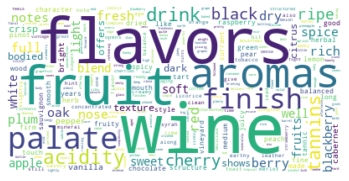

In [ ]:
#generate the world colud
word_counter = Counter(cleaned_word)
world_cloud = WordCloud(background_color="white",max_words=5000)
highest_wordcloud = world_cloud.generate_from_frequencies(word_counter)
plt.imshow(highest_wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

We can then turn a list of words back into text now.

In [ ]:
wine_df['description'] = wine_df['description'].apply(lambda x: ' '.join(w for w in x))

## 3.3 Sentiment Analysis

We use VADER for text classification. Usually, there’re two popular libraries for sentiment analysis, one is VADER, which we used here, and the other one is TextBlob. VADER is a lexicon and rule-based sentiment analysis tool that is specifically developed for interpreting sentiments from social media. TextBlob is also a rule-based sentiment analysis, but more of a natural language processing library, so it will perform better if we want to do speech tagging. Because we just focused on sentiments themselves here, we just use VADER and usually it’s the faster one.


In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# ploarity_score() will return 4 kinds of score
# 'compound' is the general score, and the other three are the socres for neg/neu/positive
def sentiment_scores(sentence):
  sia = SentimentIntensityAnalyzer()
  sentiment_dict = sia.polarity_scores(sentence)['compound'] # we choose compound as our score
  return sentiment_dict

def sentiment_label(score):
  if score > 0.05:
    return 'POSITIVE';
  elif score >= -0.05 and score <= 0.05:
    return 'NEUTRAL';
  else: 
    return 'NEGATIVE';

def sentiment_value(score):
  if score > 0.05:
    return 1;
  elif score >= -0.05 and score <= 0.05:
    return 0;
  else: 
    return -1;

In [ ]:
#find the sentiment score for each description
wine_df['sentiment'] = wine_df['description'].apply(lambda x: sentiment_scores(x))

# identify sentiment_label for each description by their sentiment score
wine_df['sentiment_label'] = wine_df['sentiment'].apply(lambda x: sentiment_label(x))

# use 1, 0, -1 to represent Positive, Neural and Negative
wine_df['sentiment_score'] = wine_df['sentiment'].apply(lambda x:sentiment_value(x))

Let's take a look at the distribution of points against sentiment label

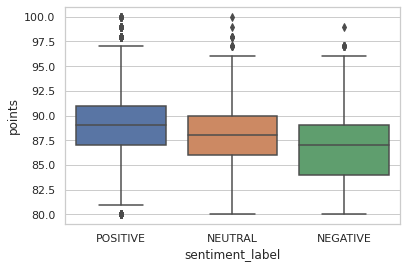

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x = 'sentiment_label',y='points',data=wine_df)

Wines that got more positive description from reviewers seems to have higher points!

Will the length of description reflect the points of the wines? Perhaps reviewers will describe more when they enjoy the wines. Let's create the regression plot for the length of description and points to see their relationship.

In [ ]:
# create column with length of description
wine_df['des_len']=wine_df['description'].apply(lambda x:len(x))

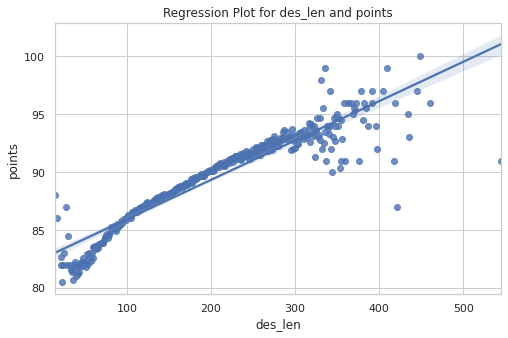

In [ ]:
plt.figure(figsize=(8,5))
len = wine_df.groupby(by='des_len').mean().reset_index()
plt.title("Regression Plot for des_len and points")
sns.regplot(x = 'des_len', y = 'points', data= len)

Length of the description have high liner relationship with points. Therefore, it is also an important feature for point prediction.

In [ ]:
#save cleaned version
wine_df.to_csv(r'/content/gdrive/My Drive/winemag-data-130k-cleaned.csv', index = False,header=True)

# Machine Learning using sklearn
We now finished wrangling and exploring our datasets. The next step is to build machine learning models to finish our predictions. We will start with linear regression using SKlearn

## 4.1 Convert features into one hot vectors
Based on our EDA result, we have decided on using price, region country, vatriety, vintage year, description length, and sentiment as our features to predict wine score. Now We now need to transfer the features into PCA through one hot encoding. We also need to clean our features a little bit because there are too many unique values under each feature.

In [ ]:
#load cleaned dataset and select feature columns
wine_df_updated = pd.read_csv('/content/gdrive/My Drive/winemag-data-130k-cleaned.csv')
wine_df_updated=wine_df_updated.rename(columns={'vintage year':'vintage_year'})
wine_df_cleaned=wine_df_updated[['points','region','country','variety','vintage_year','non_vintage','price_log','des_len','sentiment_score']]

Let's take a look at how many catagories does each feature have below. 

In [ ]:
wine_df_cleaned.nunique()

points               21
region             1560
country              42
variety             686
vintage_year         56
non_vintage           2
price_log           390
des_len             364
sentiment_score       3
dtype: int64

It seems we have way too many unique values for these categorical features: region, country, variety. We need to reduce the number of unique values for these features. Let's start with region first. We plot the % of data covered over top n unique values, but it seems our data is uniformly distributed among different regions. And we decided to keep the region for top 200 regions (which represent 80% of the data) and change the rest of regions to 'other'

(0.0, 1560.0)

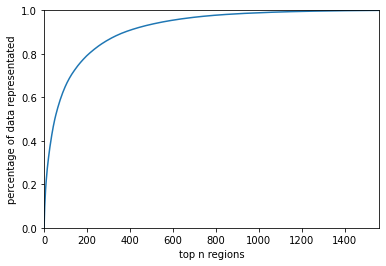

In [ ]:
import pandasql as ps #SQL on Pandas Dataframe
row = wine_df_cleaned.region.count()
# for each region compute how much % data it covers
region_distri_df= ps.sqldf('''
    SELECT region,count(price_log) as num from wine_df_cleaned
    GROUP BY region
    ORDER BY num DESC
    ''')
region_distri_df['percentage']=region_distri_df.num/row
# get cumulative sum of how much % data does top n regions cover
i=0
sum=0
end = region_distri_df['percentage'].count()
top_n=[0]
sum_top_n=[0]
while i<end:
  sum+=region_distri_df['percentage'][i]
  top_n.append(i+1)
  sum_top_n.append(sum)
  i+=1
# plot the variance chart
plt.plot(top_n,sum_top_n)
plt.ylabel("percentage of data representated")
plt.xlabel("top n regions")
axes = plt.gca()
axes.set_ylim([0,1])
axes.set_xlim([0,end])

In [ ]:
# extract top 200 regions
top_200_region = []
for i in range(200):
  top_200_region.append(region_distri_df['region'][i])
def check_region(region):
  if region not in top_200_region:
    return 'other'
  return region
# transfer regions not in top 200 to 'others'
wine_df_cleaned['region']=wine_df_cleaned['region'].apply(lambda x: check_region(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Following the same logic, we plot the % of data covered over top n unique countrys, and we found out top 15 countries cover over 95% data. We decided to keep the country for top 15 countries and change the rest of countries to 'other'

(0.0, 42.0)

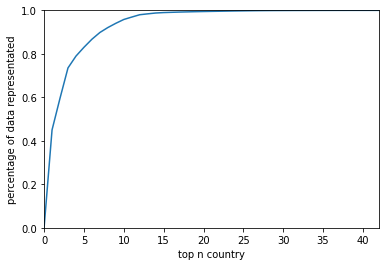

In [ ]:
# for each country compute how much % data it covers
row = wine_df_cleaned.country.count()
country_distri_df= ps.sqldf('''
    SELECT country,count(price_log) as num from wine_df_cleaned
    GROUP BY country
    ORDER BY num DESC
    ''')
country_distri_df['percentage']=country_distri_df.num/row
# get cumulative sum of how much % data does top n countries cover
i=0
sum=0
end = country_distri_df['percentage'].count()
top_n=[0]
sum_top_n=[0]
while i<end:
  sum+=country_distri_df['percentage'][i]
  top_n.append(i+1)
  sum_top_n.append(sum)
  i+=1
# plot the variance chart
plt.plot(top_n,sum_top_n)
axes = plt.gca()
plt.ylabel("percentage of data representated")
plt.xlabel("top n country")
axes.set_ylim([0,1])
axes.set_xlim([0,end])

In [ ]:
# extract top 15 countries and transfer countries not in top 15 to others
top_15_country = []
for i in range(15):
  top_15_country.append(country_distri_df['country'][i])
def check_country(country):
  if country not in top_15_country:
    return 'other'
  return country
wine_df_cleaned['country']=wine_df_cleaned['country'].apply(lambda x: check_country(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Following the same logic, we plot the % of data covered over top n unique varieties, and we found out top 50 varieties cover over 90% data. We decided to keep the variety for top 15 varieties and change the rest of varieties to 'other

(0.0, 686.0)

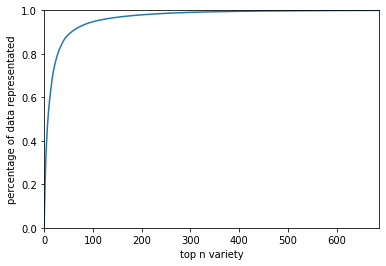

In [ ]:
# for each variety compute how much % data it covers
variety_distri_df= ps.sqldf('''
    SELECT variety,count(price_log) as num from wine_df_cleaned
    GROUP BY variety
    ORDER BY num DESC
    ''')
variety_distri_df['percentage']=variety_distri_df.num/row
# get cumulative sum of how much % data does top n varieties cover
i=0
sum=0
end = variety_distri_df['percentage'].count()
top_n=[0]
sum_top_n=[0]
while i<end:
  sum+=variety_distri_df['percentage'][i]
  top_n.append(i+1)
  sum_top_n.append(sum)
  i+=1
# plot the variance chart
plt.plot(top_n,sum_top_n)
axes = plt.gca()
plt.ylabel("percentage of data representated")
plt.xlabel("top n variety")
axes.set_ylim([0,1])
axes.set_xlim([0,end])

In [ ]:
# extract top 50 varieties and transfer varieties not in top 50 to others
top_50_variety = []
for i in range(50):
  top_50_variety.append(variety_distri_df['variety'][i])
def check_variety(variety):
  if variety not in top_50_variety:
    return 'other'
  return variety
wine_df_cleaned['variety']=wine_df_cleaned['variety'].apply(lambda x: check_variety(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's take look at unique count for each feature again. It seems we successfuly reduced the unique values for categorical datas from over 2000+ unique values to 300- unique values. This is great and we can move to the next step in training the model.

In [ ]:
wine_df_cleaned.nunique()

points              21
region             201
country             16
variety             51
vintage_year        56
non_vintage          2
price_log          390
des_len            364
sentiment_score      3
dtype: int64

Before we move one, let's convert categorical data using one hot encoding and drop useless columns

In [ ]:
wine_df_cleaned['non_vintage'] = wine_df_cleaned['non_vintage'].apply(lambda x: 1 if x else 0)
wine_df_cleaned.country = wine_df_cleaned.country.astype('category')
wine_df_cleaned.variety = wine_df_cleaned.variety.astype('category')
wine_df_cleaned.region = wine_df_cleaned.region.astype('category')

wine_df_cleaned = pd.concat([wine_df_cleaned,pd.get_dummies(wine_df_cleaned.country,prefix='country')],axis=1)
wine_df_cleaned = pd.concat([wine_df_cleaned,pd.get_dummies(wine_df_cleaned.variety,prefix='variety')],axis=1)
wine_df_cleaned=wine_df_cleaned.drop(columns=['variety','country','region'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## 4.2 Split data into train and test
We will start with a training size split of 0.2 and adjust later if necessary

In [ ]:
label = wine_df_cleaned['points']
features = wine_df_cleaned.drop(columns=['points'])
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2)

## 5.1 Linear Regression

### 5.1.1 Simple Linear Regression
Let's train our first model

In [ ]:
clf = LinearRegression()
clf.fit(x_train,y_train)
y_pred_train=clf.predict(x_train)
y_pred_test = clf.predict(x_test)
mse_test = mean_squared_error(y_test,y_pred_test)
mse_train = mean_squared_error(y_train,y_pred_train)
r2_test=r2_score(y_test,y_pred_test)
explained_variance_test=explained_variance_score(y_test,y_pred_test)
test_score=clf.score(x_test,y_test)
r2_train=r2_score(y_train,y_pred_train)
explained_variance_train=explained_variance_score(y_train,y_pred_train)
train_score=clf.score(x_train,y_train)

Let's see what are the most significant features in our linear regression. Not surprisingly, price is the most important factor that indicate how good the wine is. We also have year, the length of description and the tune of description impacting the quality. Our other features like country seems have very high covariance, definitely something we need to pay attention to improve our model.

In [ ]:
coefficients = pd.concat([pd.DataFrame(x_train.columns,columns=['coef']),pd.DataFrame(np.transpose(clf.coef_),columns=['val'])], axis = 1)
posi_df=coefficients.sort_values(by='val',ascending=False).head(4).reset_index(drop=True)
posi_df

,coef,val
0,price_log,2.208236
1,sentiment_score,0.552588
2,vintage_year,0.094547
3,des_len,0.029619


In [ ]:
neg_df=coefficients.sort_values(by='val').head(5).reset_index(drop=True)
neg_df

,coef,val
0,country_Argentina,-2.052590e+10
1,country_Chile,-2.052590e+10
2,country_South Africa,-2.052590e+10
3,country_Israel,-2.052590e+10
4,country_Spain,-2.052590e+10


Let's also take a look at our mean squared error and score. Our test score and train score are very simialr so there's no overfitting in our data. But can we reduce our MSE?

In [ ]:
print("Test Score: ",test_score)
print("Test MSE: ",mse_test)

print("Train Score: ",train_score)
print("Train MSE: ",mse_train)

Test Score:  0.5862580702372169
Test MSE:  3.9636601689307187
Train Score:  0.5865756538598146
Train MSE:  3.9744715086343785


###5.1.2 Learning Curve
Before we start tuning our model, let's see if we need to adjust our train test split and it seems different train test size does not impact our accuracy, so let's keep our current split.

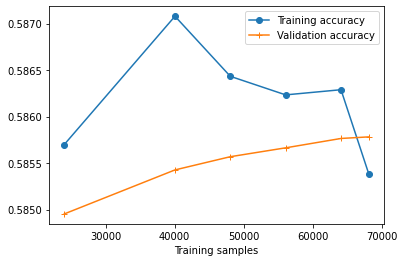

In [ ]:
train_sizes, train_scores, test_scores = \
  learning_curve(estimator=clf, X=x_train,
                 y=y_train,
                 train_sizes=[0.3, 0.5, 0.6, 0.7, 0.8, 0.85],
                 cv=10)
  
plt.plot(train_sizes,np.mean(train_scores, axis=1), \
          marker='o', label='Training accuracy')
plt.plot(train_sizes,np.mean(test_scores, axis=1), \
          marker='+', label='Validation accuracy')
plt.xlabel('Training samples')
plt.legend()

### 5.1.3 Dimensionality reduction with PCA
One way to improve our model is to reduce correlation. Let's take a look at if our data is correlated. There seems big room to improve!

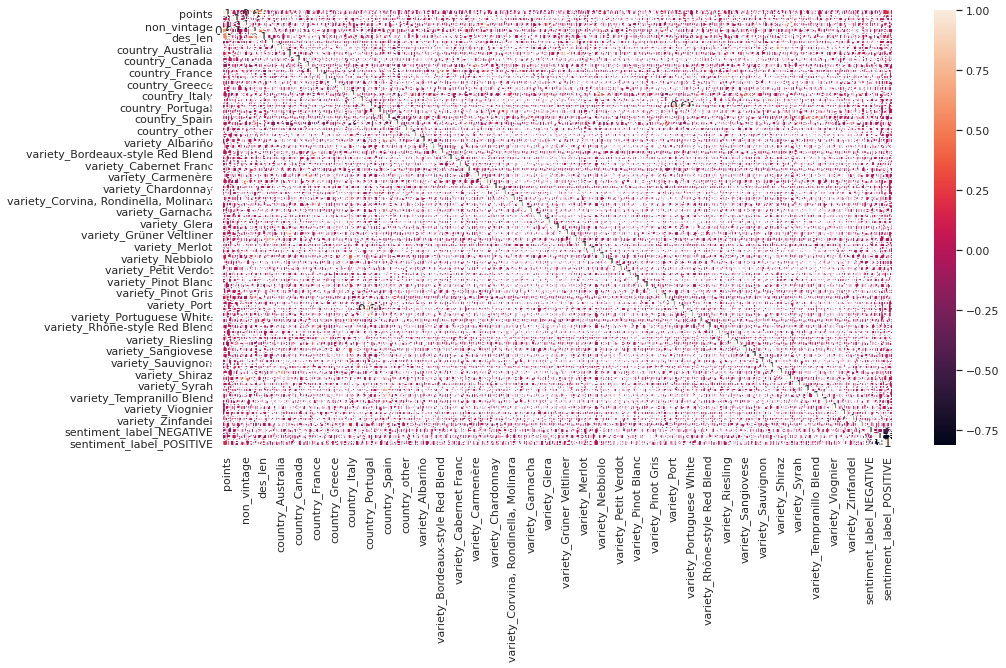

In [ ]:
corr_matrix=wine_df_cleaned.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

After ploting the variance chart below we found out we can reduce our n_component from ~400 to 20!


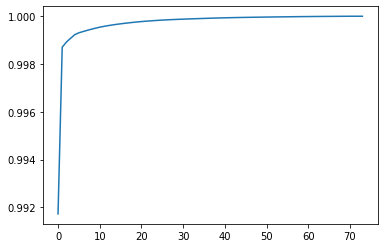

In [ ]:
pca = PCA().fit(x_train)
pc_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_variance)

In [ ]:
pca=PCA(n_components=20)
pca.fit(x_train)
x_train_PCA=pca.transform(x_train)
x_test_PCA=pca.transform(x_test)
clf_PCA = LinearRegression()
clf_PCA.fit(x_train_PCA,y_train)
y_pred = clf_PCA.predict(x_test_PCA)
mse_test_PCA = mean_squared_error(y_test,y_pred)
explained_variance_test_PCA=explained_variance_score(y_test,y_pred)
test_score_PCA=clf_PCA.score(x_test_PCA,y_test)

Let's see if our model compromised too much after we reduced PCA, not a lot! We successfully reduced covariance in our data while maintaining MSE.

In [ ]:
print("Score: ",test_score_PCA)
print("MSE: ",mse_test_PCA)

Score:  0.5740005720286121
MSE:  4.075080968718065


### 5.1.4 Regularization
Add regularization to avoid overfitting.

In [ ]:
#ridge
rd = Ridge(alpha=0.01)
rd.fit(x_train_PCA, y_train) 
pred_train_rd= rd.predict(x_train_PCA)

pred_test_rd= rd.predict(x_test_PCA)
mse_rd=mean_squared_error(y_test,pred_test_rd)
score_rd=r2_score(y_test, pred_test_rd)

In [ ]:
print("Score: ",score_rd)
print("MSE: ",mse_rd)

Score:  0.5778700734274897
MSE:  4.097238060404497


In [ ]:
#lasso
ls = Lasso(alpha=0.01)
ls.fit(x_train_PCA, y_train) 
pred_train_ls= ls.predict(x_train_PCA)

pred_test_ls= ls.predict(x_test_PCA)
mse_ls=mean_squared_error(y_test,pred_test_ls)
score_ls=r2_score(y_test, pred_test_ls)

In [ ]:
print("Score: ",score_ls)
print("MSE: ",mse_ls)

Score:  0.565589056595536
MSE:  4.171490500844219


In [ ]:
#Elastic Net
eln = ElasticNet(alpha=0.01)
eln.fit(x_train_PCA, y_train) 
pred_train_eln= eln.predict(x_train_PCA)

pred_test_eln= eln.predict(x_test_PCA)
mse_eln=mean_squared_error(y_test,pred_test_eln)
score_eln=r2_score(y_test, pred_test_eln)

In [ ]:
print("Score: ",score_eln)
print("MSE: ",mse_eln)

Score:  0.5668262429735824
MSE:  4.159610249432161


## 5.2 Fitting using Random Forest
Now let's try fitting using randomforest. We use gridsearch to decide what estimator and depth to use. 

In [ ]:
rfc = RandomForestRegressor(n_estimators = 6, max_depth=100)
param={
    #'n_estimators':[4,5,6],
    #'max_depth':[90,100,110]
    'n_estimators':[10,50,100],
    'max_depth':[100,130,150]
}
gs = GridSearchCV(estimator = rfc, param_grid=param,cv=3,scoring='neg_mean_squared_error')
gs.fit(x_train_PCA,y_train)
#save the RF model
pkl_filename = "gdrive/MyDrive/545_project_RF_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(gs, file)

In [ ]:
pkl_filename = "gdrive/MyDrive/545_project_RF_model.pkl"
with open(pkl_filename, 'rb') as file:
    gs = pickle.load(file)
y_pred=gs.predict(x_test_PCA)
mse_fitted=mean_squared_error(y_test, y_pred)
score_fitted=gs.score(x_test_PCA,y_test)

After applying random forrest, our MSE improves a bit

In [ ]:
print("MSE: ",mse_fitted)

MSE:  3.99526598106252


## 5.3 KNN
Maybe our model is non-Linear! Let's try some other regressions like KNN. We are not sure how many clusters to start with, so let's print out the performance from 1-20 clusters. To imporve our running time. We will be using training data after PCA reduced.

In [ ]:
rmse_val = []
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train_PCA, y_train)  #fit the model
    pred=model.predict(x_test_PCA) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate mse
    rmse_val.append(error) #store rmse values
    print('MSE value for k= ' , K , 'is:', error)

MSE value for k=  1 is: 8.00530432437292
MSE value for k=  2 is: 6.086779645779017
MSE value for k=  3 is: 5.449623902424406
MSE value for k=  4 is: 5.146430819023645
MSE value for k=  5 is: 4.979780634720849
MSE value for k=  6 is: 4.876816806017562
MSE value for k=  7 is: 4.79530371889833
MSE value for k=  8 is: 4.749768216758069
MSE value for k=  9 is: 4.706082824710892
MSE value for k=  10 is: 4.6835368156073
MSE value for k=  11 is: 4.667428000799474
MSE value for k=  12 is: 4.655307570899137
MSE value for k=  13 is: 4.642504975297734
MSE value for k=  14 is: 4.643781638340853
MSE value for k=  15 is: 4.6436582856343716
MSE value for k=  16 is: 4.63734649628023
MSE value for k=  17 is: 4.634177226215701
MSE value for k=  18 is: 4.63232244276402
MSE value for k=  19 is: 4.627869481593753
MSE value for k=  20 is: 4.629003191585004


Looks like our MSE improves very slow after k>15, let's use GridSearch to find out which k should be use. GridSearch identifies 17 as the best cluster to use.

In [ ]:
knn = neighbors.KNeighborsRegressor()
parameters = {'n_neighbors':[15,17,19,21,23,25,27,29]}

#Fit the model
gs = GridSearchCV(knn, param_grid=parameters)
gs.fit(x_train_PCA,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [15, 17, 19, 21, 23, 25, 27, 29]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# take a look at the returned metrics
gs.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                    weights='uniform')

In [ ]:
#save the KNN model
pkl_filename = "545_project_KNN_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(gs, file)
with open(pkl_filename, 'rb') as file:
    gs = pickle.load(file)

In [ ]:
#predictions on test data
knn_prediction=gs.predict(x_test_PCA)
mse_knn=mean_squared_error(y_test, y_pred)
score_knn=gs.score(x_test_PCA,y_test)
print("Score: ",score_knn)
print("MSE: ",mse_knn)

Score:  0.518167682328005
MSE:  3.914084393023175


KNN performs slightly better than random forrest.

## 5.4 SVM
We decided to try Radial Basis Function and polynomial regression with SVM

In [ ]:
#rbf
svm_rbf = SVR(kernel='rbf')
svm_rbf.fit(x_train_PCA,y_train)
pred_test_rbf=svm_rbf.predict(x_test_PCA)
#save the rbf model
pkl_filename = "545_project_rbf_model.pkl"


In [ ]:
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm_rbf, file)
pkl_filename = "545_project_rbf_model.pkl"
with open(pkl_filename, 'rb') as file:
    svm_rbf = pickle.load(file)

In [ ]:
pred_test_rbf=svm_rbf.predict(x_test_PCA)
mse_rbf=mean_squared_error(y_test,pred_test_rbf)
score_rbf=r2_score(y_test, pred_test_rbf)
print("Score: ",score_rbf)
print("MSE: ",mse_rbf)

Score:  0.572716105766135
MSE:  4.0789367076203025


In [ ]:
#poly
svm_poly= SVR(kernel='poly')
svm_poly.fit(x_train_PCA,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#save the rbf model
pkl_filename = "545_project_poly_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm_poly, file)
with open(pkl_filename, 'rb') as file:
    svm_poly = pickle.load(file)

In [ ]:
pred_test_poly=svm_poly.predict(x_test_PCA)
mse_poly=mean_squared_error(y_test,pred_test_poly)
score_poly=r2_score(y_test, pred_test_poly)
print("Score: ",score_poly)
print("MSE: ",mse_poly)

Score:  0.10648738104301791
MSE:  8.672528715429516


The rbf model fits similarly with linear regression, but polynomial model pretty bad, so our dataset is definitely not polynomial!

# Machine learning using Catboost

From our previous modeling we noticed the description of the wine plays an import role in our model, so we want to dive deeper into wine description and include our NLP results in modeling. However, one-hot-coding on all those features we extracted from descriptions will take a long time with SKlearn. After searching, we choose to use catboost for fitting, because it doesn't require data prepocessing and can furture reduce bias and variance in our data.

### 6.1 Data preprocessing

Bag-of-words model (BoW) is the simplest way of extracting features from the text. BoW converts text into the matrix of occurrence of words within a document. This model concerns about whether given words occurred or not in the document.
Another simple way to do that is TF-IDF (Term Frequency-Inverse Document Frequency).
TF-IDF(Term Frequency-Inverse Document Frequency) normalizes the document term matrix. It is the product of TF and IDF. Term frequency is basically the output of the BoW model. IDF(Inverse Document Frequency) measures the amount of information a given word provides across the document. Word with high tf-idf is most of the times occurred in given documents and must be absent in the other documents. So the words must be most significant ones.


Let's try BoW(Bag Of Words) first.

In [ ]:
wine_df =  pd.read_csv('/content/gdrive/My Drive/winemag-data-130k-cleaned.csv')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
vect= CountVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
vectorized=vect.fit_transform(wine_df['description'])
X_train, X_test, y_train, y_test = train_test_split(
    vectorized, wine_df['sentiment_score'], test_size=0.2, random_state=42)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.827474602175672


Then, let's try using Tf-IDF(Term Frequency — Inverse Document Frequency”).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf=TfidfVectorizer().fit_transform(wine_df['description'])
X_train, X_test, y_train, y_test = train_test_split(
    tf, wine_df['sentiment_score'], test_size=0.2, random_state=42)

In [ ]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.7658455452665648


Compared the accuracy of those two methods, we choose BoW to do the vectorization.

## 6.2 CatBoost Regression
Now, it’s time for us to do the modeling. Due to the categorical features in the dataframe, we need to do one-hot-encoding first. But the dataframe we get now is much larger because of hundreds of features from the text classification. Also, the categorical features in this dataset, like variety, have too many unique values, and it will make it harder for us to do the encoding because it will take a long time for computing. After searching and learning from other works online, we find a useful tool that can skip the preprocessing of the data, it is called catboost.
While in random forest, a decision tree is built for each sample, in gradient boosting, new tree will be created after the old one, so it can use the results from the previous tree to improve performance. CatBoost is an algorithm for gradient boosting on decision trees. Usually, we need to pre-process our data by one-hot encoding or label encoding, so that we can do analysis of categorical features. But when using CatBoost, we no longer need to do the data preparation part, catboost can do it for us automatically, also, it can handle missing values in our data.

Reference: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python,
https://heartbeat.fritz.ai/fast-gradient-boosting-with-catboost-38779b0d5d9a.

### 6.2.1 Fitting with All Features
Because CatBoost allows us to use many features, let's just use all features to fit our model first and see how it performs compared with previous models. Result is pretty good! Error is low than all preivous models, so let's try to further tune our model.

In [ ]:
from catboost import CatBoostRegressor
#combine the features extracted from descriptions with the original df
vectorized = pd.DataFrame(vectorized.toarray())
combined_df = pd.concat([wine_df.reset_index(),vectorized.reset_index()],axis = 1)
combined_df.drop(columns = ['sentiment_label','sentiment'])   
cb_df = combined_df.drop(columns = ['sentiment_score','winery','non_vintage','description','sentiment_label','sentiment','index'])
cb_df.to_csv(r'/content/gdrive/My Drive/winemag-data-after-nlp.csv', index = False,header=True)
cb_df_updated = pd.read_csv('/content/gdrive/My Drive/winemag-data-after-nlp.csv')

In [ ]:
X = cb_df.drop(columns=['points'])
y = cb_df[['points']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                        random_state=42)

In [ ]:
SEED = 42
categorical_features_indices = [0,1,2,3]
model=CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE',eval_metric='RMSE',random_seed= SEED)
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_valid, y_valid),verbose = False,plot=True)
print(model.get_best_score())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 1.70676957741584}, 'validation': {'RMSE': 1.7026740301206313}}


### 6.2.2 Features Selection
Because we have too many features now, we first model with catboost regression to get feature importance, so that we can just keep those most important ones. Let's take a look at the importance of top 20 features to get some idea on how many features should we select. It seems most importance are captured by top 5 features, but it's a little hard to decide on how many features should we select because the top 20 most important features does not capture 90+ importance score. We will need to take a look at other features as well.

In [ ]:
from catboost import Pool
im = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features_indices))
feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, im )),
                                        columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
feature_score['score_percentage'] = feature_score['Score'].apply(lambda x: x/100).astype('float')


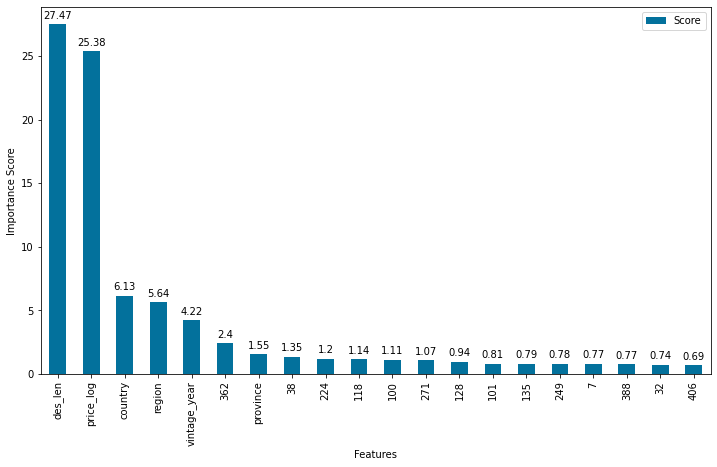

In [ ]:
plt.rcParams["figure.figsize"] = (12,6.75)
#plot with the top 20 important features
ax = feature_score.head(20).plot('Feature', 'Score', kind='bar', color='xkcd:ocean blue')
ax.set_xlabel("Features")
ax.set_ylabel("Importance Score")
rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.3, label, ha='center', va='bottom')
plt.show()

After ploting the variance chart we we see top 50 features can represent 95% importance, so we just choose those ones.

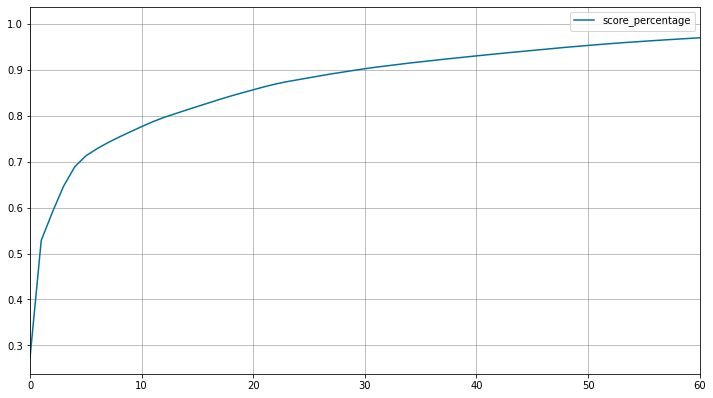

In [ ]:
plt.rcParams["figure.figsize"] = (12,6.75)
feature_importance = feature_score[['score_percentage']].cumsum().reset_index()
ax = feature_importance.plot.line(y = 'score_percentage',xlim=(0,60),color='xkcd:ocean blue')
ax.grid(linestyle='-', linewidth='0.5', color='grey')

In [ ]:
chosen_features = feature_score['Feature'].head(50).to_list()

### 6.2.3 Fitting Again with Selected Features
Now we have selected our features, we are going to model with CatBoostRegressor again, using RMSE as evaluation metric.

In [ ]:
X = cb_df[[i for i in chosen_features]]
categorical_features_indices =[2,3,6]
y = cb_df[['points']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                        random_state=42)

We used grid search again to tune hyperparameters for the catboost regressor model.

In [ ]:
grid_model = CatBoostRegressor(loss_function='RMSE',eval_metric='RMSE',random_seed = SEED,cat_features=categorical_features_indices)

grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'iterations':[1000,1500,2000]
        }

grid_search_result = grid_model.grid_search(grid, 
                                       X_train,y_train)


bestTest = 1.805731893
bestIteration = 999

0:	loss: 1.8057319	best: 1.8057319 (0)	total: 31.9s	remaining: 1h 11m 10s

bestTest = 1.668666588
bestIteration = 999

1:	loss: 1.6686666	best: 1.6686666 (1)	total: 1m 3s	remaining: 1h 10m 12s

bestTest = 1.651411558
bestIteration = 999

2:	loss: 1.6514116	best: 1.6514116 (2)	total: 1m 34s	remaining: 1h 9m 34s

bestTest = 1.806320776
bestIteration = 999

3:	loss: 1.8063208	best: 1.6514116 (2)	total: 2m 6s	remaining: 1h 9m 7s

bestTest = 1.671263396
bestIteration = 999

4:	loss: 1.6712634	best: 1.6514116 (2)	total: 2m 38s	remaining: 1h 8m 31s

bestTest = 1.654491449
bestIteration = 999

5:	loss: 1.6544914	best: 1.6514116 (2)	total: 3m 9s	remaining: 1h 7m 59s

bestTest = 1.808705013
bestIteration = 999

6:	loss: 1.8087050	best: 1.6514116 (2)	total: 3m 41s	remaining: 1h 7m 32s

bestTest = 1.674951037
bestIteration = 999

7:	loss: 1.6749510	best: 1.6514116 (2)	total: 4m 13s	remaining: 1h 7m

bestTest = 1.657490607
bestIteration = 999

8:	loss: 1

Below is MSE after tuning the model


In [ ]:
y_pred = grid_model.predict(X_test)
mse_cbf=mean_squared_error(y_test,y_pred)
score_cbf=r2_score(y_test, y_pred)
print("Score: ",score_cbf)
print("MSE: ",mse_cbf)

Score:  0.730648576934174
MSE:  2.582987019970741


# Conclusion
We have finished our model with wine quality prediction and here is a recap with our journey. We started with wrangling and exploring our data by looking at different features of the dataset, and then find out that price and description length have high linear relationship with points. Through the process we decided to focus on using price, description, country, variety as key features for our model. Then we tried with different type of machine learning including linear regression, random forrest, KNN, and SVM. We found some models (like random forrest) fit better than other models (like polynomial regression with SVM). We also improved our model by applying PCA to reduce covariance and different regularization. Our best performing model ended up with MSE 3.91. By looking at the result of our models we realized price, positive and long descriptions play import roles in wine score. We want to dive deeper with description using nlp. We chosed Catboost regression which successfully reduced our MSE to 2.58 (40% improvement. Here is the overall performane of different models on our dataset: Catboost > KNN > Random Forrest > Linear Regression = SVM RBF > SVM Polynomial


## 7.1 Challenges

  Data preprocessing make us realized that dataset in the real world is much more complicated to handle compared to those done in homework. For example, we can drop the nan value in the homework, but in reality, the missing values can sometimes take a large percentage in our dataset so that we can't drop them. We need to find a suitable way to give them value.


  When exploring our data, we also encounter the situation that our numeric features like price and vintage year have a lot of outliers. Most of the time others will suggest dropping the data. However, it is necessary for us to check where are these outliers come from. Based on our knowledge of wines and after searching the internet, we found that 3300 USD is a normal wine price in the world. So we decide to keep them in the dataset.


  How to analyze the description is also challenging, what kind of process should be done to turn the description into an indicator of the quality? After considering different methods, we found that sentiment analysis by VADER is an applicable method. Since the positive description means that reviewers are satisfied with the taste of wines. Our result can also prove that.

  When building machine learning models we found tuning the accuracy of our model to be quite difficult. Although we applied various models and different hyperparameter, our models do not improve much. But luckily we are able to identify the correct direction through applying different models and use boosting to finally improve our model.

## 7.2 Next Steps/Future Direction

Our analysis can be improved in the following ways:

*   Larger dataset with more data from differnet countries, not only from famous countries like US, Italy and France.
*   Larger dataset with more expensive wines and earlier vintage year.
*   More wine features from the bottle like ingrediant and alchocal % because we found high covariance in current features
*   Try different machine learning models including learning based on wine pictures (pictures of the bottle)





